# Import needed modules

In [1]:
import os
import time
import shutil
import pathlib
import itertools 

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")

# Create Needed Functions

**Function to create data frame**

In [2]:
def define_paths(data_dir):
    filepaths = []
    labels = []
    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    return filepaths, labels

def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

def split_data(train_dir, test_dir):
    files, classes = define_paths(train_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, valid_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)  
    files, classes = define_paths(test_dir)
    test_df = define_df(files, classes)
    return train_df, valid_df, test_df

 **Function to generate images from dataframe**

In [3]:
def create_gens (train_df, valid_df, test_df, batch_size):
    img_size = (224, 224)
    channels = 3 
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size
    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function=scalar,horizontal_flip=True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)

    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size)

    return train_gen, valid_gen, test_gen

**Function to display data sample**

In [4]:
def show_images(gen):
    g_dict = gen.class_indices        
    classes = list(g_dict.keys())     
    images, labels = next(gen)        
    length = len(labels)        
    sample = min(length, 25)    
    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       
        plt.imshow(image)
        index = np.argmax(labels[i])  
        class_name = classes[index]   
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

**Callbacks** 

In [5]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience 
        self.stop_patience = stop_patience
        self.threshold = threshold 
        self.factor = factor 
        self.batches = batches 
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch 

        # callback variables
        self.count = 0 # how many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1   # epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initial learning rate and save it
        self.highest_tracc = 0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf # set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights = self.model.get_weights()   # save initial weights if they have to get restored

    # Define a function that will run when train begins
    def on_train_begin(self, logs= None):
        msg = 'Do you want model asks you to halt the training [y/n] ?'
        print(msg)
        ans = input('')
        if ans in ['Y', 'y']:
            self.ask_permission = 1
        elif ans in ['N', 'n']:
            self.ask_permission = 0

        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()


    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)

        # set the weights of the model to the best weights
        self.model.set_weights(self.best_weights)


    def on_train_batch_end(self, batch, logs= None):
        # get batch accuracy and loss
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')

        # prints over on the same line to show running batch count
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '')


    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()


    # Define method runs on the end of each epoch
    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr = lr
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        loss = logs.get('loss')  # get training loss for this epoch
        v_loss = logs.get('val_loss')  # get the validation loss for this epoch

        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc # define improvement of model progres

            if acc > self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc = acc # set new highest training accuracy
                self.best_weights = self.model.get_weights() # training accuracy improved so save the weights
                self.count = 0 # set count to 0 since training accuracy improved
                self.stop_count = 0 # set stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # set the value of best epoch for this epoch

            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count >= self.patience - 1: # lr should be adjusted
                    lr = lr * self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count = 0 # reset the count to 0
                    self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count = 0 # reset counter
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 # increment patience counter

        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0

            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss

            if v_loss < self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss = v_loss # replace lowest validation loss with new validation loss
                self.best_weights = self.model.get_weights() # validation loss improved so save the weights
                self.count = 0 # reset count since validation loss improved
                self.stop_count = 0
                self.best_epoch = epoch + 1 # set the value of the best epoch to this epoch

            else: # validation loss did not improve
                if self.count >= self.patience - 1: # need to adjust lr
                    lr = lr * self.factor # adjust the learning rate
                    self.stop_count = self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count = 0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer

                else:
                    self.count = self.count + 1 # increment the patience counter

                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True # stop training

        else:
            if self.ask_epoch != None and self.ask_permission != 0:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                    print(msg)

                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True # stop training

                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f' training will continue until epoch {str(self.ask_epoch)}'
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                            print(msg)

                        except Exception:
                            print('Invalid')

**Fuction to plot History**

In [6]:
def plot_training(hist):

    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

**Function to create Confusion Matrix**

In [7]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    print('Confusion Matrix:')
    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

In [8]:
def plot_roc_auc(y_true, y_pred_prob, classes, model_name):
    plt.figure(figsize=(12, 10))
    if len(classes) > 2:
        y_true_binarized = label_binarize(y_true, classes=range(len(classes)))  # Binarize true labels
        colors = cm.tab20.colors if len(classes) <= 20 else cm.hsv(np.linspace(0, 1, len(classes)))
        
        for i, class_label in enumerate(classes):
            fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_pred_prob[:, i])  # Compute ROC for each class
            roc_auc = auc(fpr, tpr) 
            
            plt.plot(fpr, tpr, lw=2, alpha=0.8, label=f'Class {class_label} (AUC = {roc_auc:.2f})', color=colors[i % len(colors)])

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, alpha=0.6, label='Random Model (AUC = 0.50)')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title(f'ROC Curve for {model_name}', fontsize=16)
    plt.grid(alpha=0.4)
    
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=10, title="Classes", ncol=1, frameon=True)
    plt.tight_layout()
    plt.show()

**Reading Dataset**

In [9]:
train_dir = '/kaggle/input/tree-dataset-of-urban-street-classification-leaf/leaf/train'
test_dir = '/kaggle/input/tree-dataset-of-urban-street-classification-leaf/leaf/test'

try:
    train_df, valid_df, test_df = split_data(train_dir, test_dir)
    batch_size = 40
    train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

except:
    print('Invalid Input')

Found 13534 validated image filenames belonging to 50 classes.
Found 3384 validated image filenames belonging to 50 classes.
Found 2092 validated image filenames belonging to 50 classes.


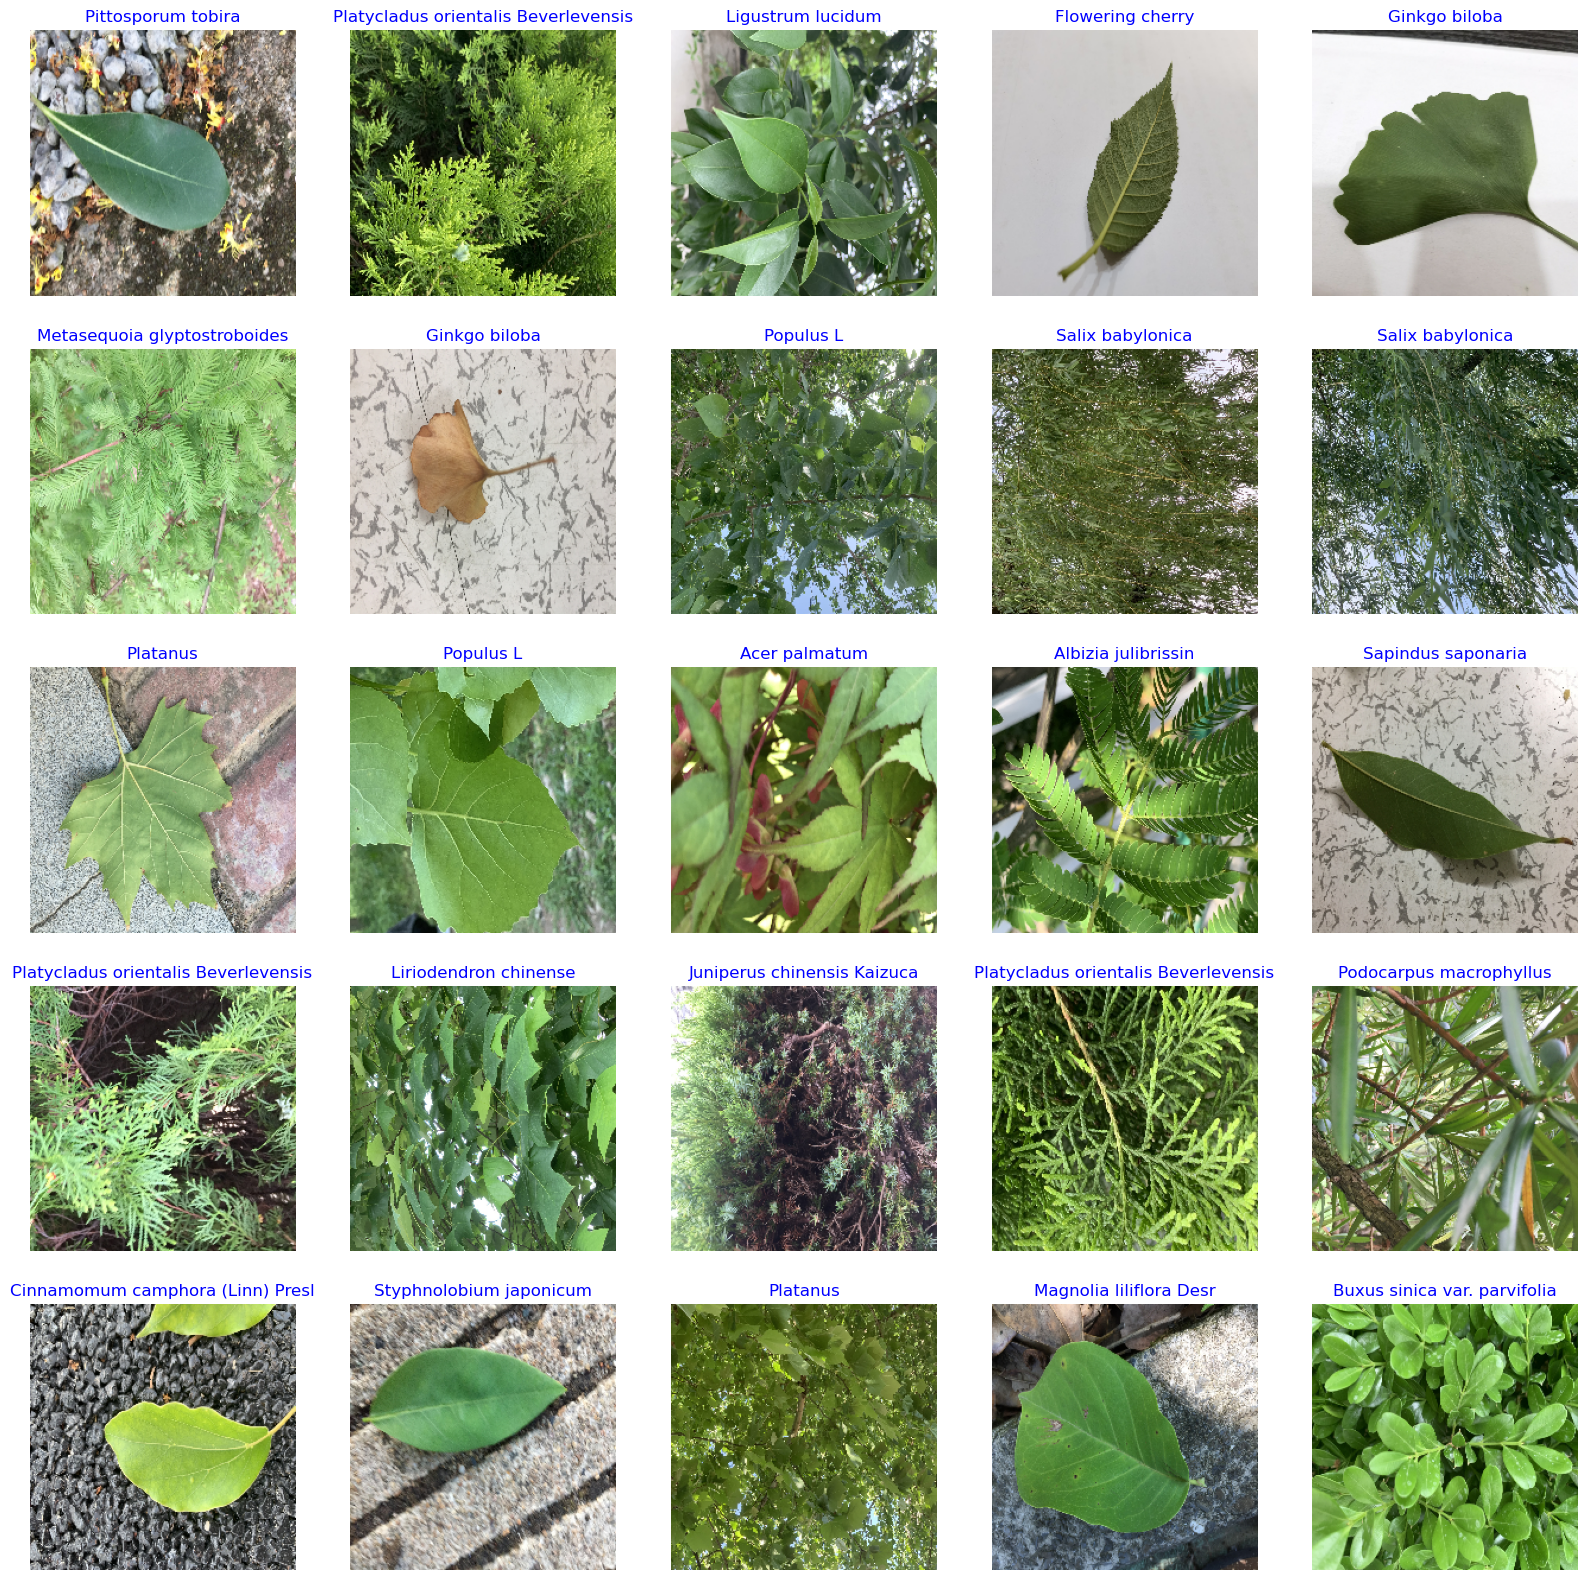

In [10]:
show_images(train_gen) 

# **Xception Model**

In [11]:
img_size_xception = (224, 224)
channels_xception = 3
img_shape_xception = (img_size_xception[0], img_size_xception[1], channels_xception)
class_count_xception = len(list(train_gen.class_indices.keys()))  

base_model_xception = tf.keras.applications.xception.Xception(include_top=False, weights="imagenet", input_shape=img_shape_xception, pooling='max')
base_model_xception.trainable = True

model_xception = Sequential([base_model_xception,BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu'),
    Dropout(rate=0.5, seed=123),
    Dense(class_count_xception, activation='softmax')
])

model_xception.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model_xception.summary() 

83683744/83683744 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 batch_normalization_4 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                12850     
                                                                 
Total params: 21,407,066
Trainable params: 21,348,442
Non

In [12]:
batch_size_xception =32
callbacks_xception = [MyCallback(model=model_xception, patience=1, stop_patience=3, threshold=0.9 ,factor=0.5, 
                            batches=int(np.ceil(len(train_gen.labels) / batch_size_xception)),epochs=10, ask_epoch= 5)]

In [13]:
history_xception = model_xception.fit(x=train_gen, epochs=10, verbose=0, callbacks=callbacks_xception,  
                                       validation_data=valid_gen, validation_steps=None, shuffle=False) 

Do you want model asks you to halt the training [y/n] ?


 n


 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /10     7.901   53.118   4.98934  83.452   0.00100  0.00100  accuracy     0.00    825.97 
 2 /10     3.712   87.653   2.55803  92.139   0.00100  0.00100  accuracy    65.02    575.34 
 3 /10     1.871   95.397   1.36343  94.681   0.00100  0.00100  val_loss    46.70    572.31 
 4 /10     1.056   97.495   0.92355  94.829   0.00100  0.00100  val_loss    32.26    566.83 
 5 /10     0.724   98.426   0.71267  95.863   0.00100  0.00100  val_loss    22.83    568.95 
 6 /10     0.600   98.751   0.62174  96.070   0.00100  0.00100  val_loss    12.76    572.02 
 7 /10     0.516   99.128   0.57501  96.040   0.00100  0.00100  val_loss     7.52    567.17 
 8 /10     0.468   99.409   0.55191  95.863   0.00100  0.00100  val_loss     4.02    568.15 
 9 /10     0.424   99.616   0.48408  96.602   0.00100  0.00100  val_loss    12.29    567.94 
10 /10     0.403   99.498   0.51184  95.686   0.00100  0.00050  val_los

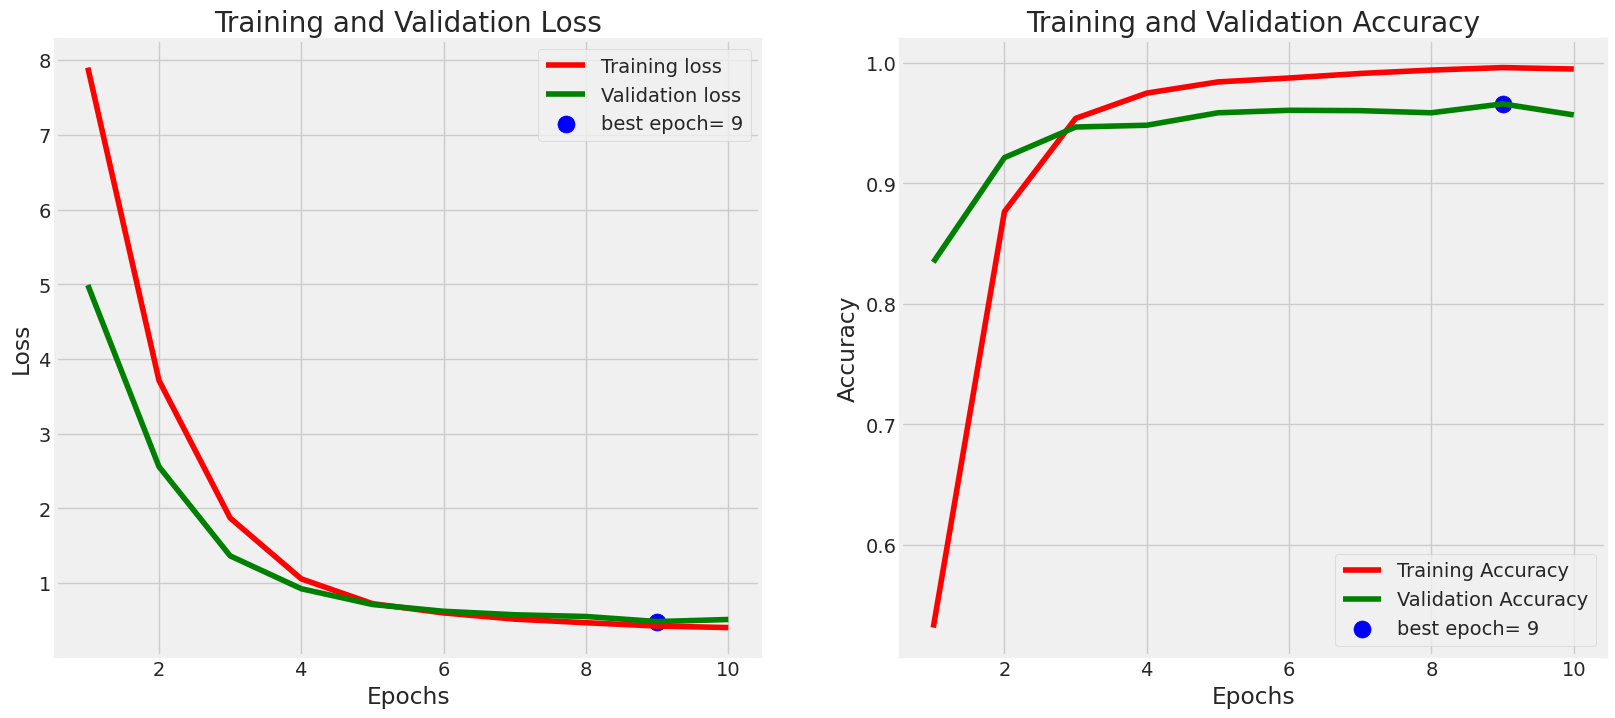

In [14]:
plot_training(history_xception)

**Evaluate xception model**

In [15]:
ts_length_xception = len(test_df)
test_batch_size_xception = max(sorted([ts_length_xception // n for n in range(1, ts_length_xception + 1) if ts_length_xception % n == 0 and ts_length_xception / n <= 80]))
test_steps_xception = ts_length_xception // test_batch_size_xception

train_score_xception = model_xception.evaluate(train_gen, steps=test_steps_xception, verbose=1)
valid_score_xception = model_xception.evaluate(valid_gen, steps=test_steps_xception, verbose=1)
test_score_xception = model_xception.evaluate(test_gen, steps=test_steps_xception, verbose=1)

print("Xception Model Accuracy")
print("Train Loss: ", train_score_xception[0])
print("Train Accuracy: ", train_score_xception[1])
print('-' * 20)
print("Validation Loss: ", valid_score_xception[0])
print("Validation Accuracy: ", valid_score_xception[1])
print('-' * 20)
print("Test Loss: ", test_score_xception[0])
print("Test Accuracy: ", test_score_xception[1])

523/523 [==============================] - 101s 193ms/step - loss: 0.4802 - accuracy: 0.9699
Xception Model Accuracy
Train Loss:  0.354846328496933
Train Accuracy:  0.9989655613899231
--------------------
Validation Loss:  0.48407652974128723
Validation Accuracy:  0.9660165309906006
--------------------
Test Loss:  0.48020872473716736
Test Accuracy:  0.9698852896690369


In [16]:
preds_xception = model_xception.predict(test_gen)
y_pred_xception = np.argmax(preds_xception, axis=1)
print(y_pred_xception)

523/523 [==============================] - 72s 136ms/step
[28 28 28 ...  1  1  1]


Confusion Matrix:
[[38  0  1 ...  0  0  0]
 [ 0 45  0 ...  0  0  0]
 [ 0  0 45 ...  0  0  0]
 ...
 [ 0  0  0 ... 44  0  0]
 [ 0  0  0 ...  0 40  0]
 [ 0  0  0 ...  0  0 40]]


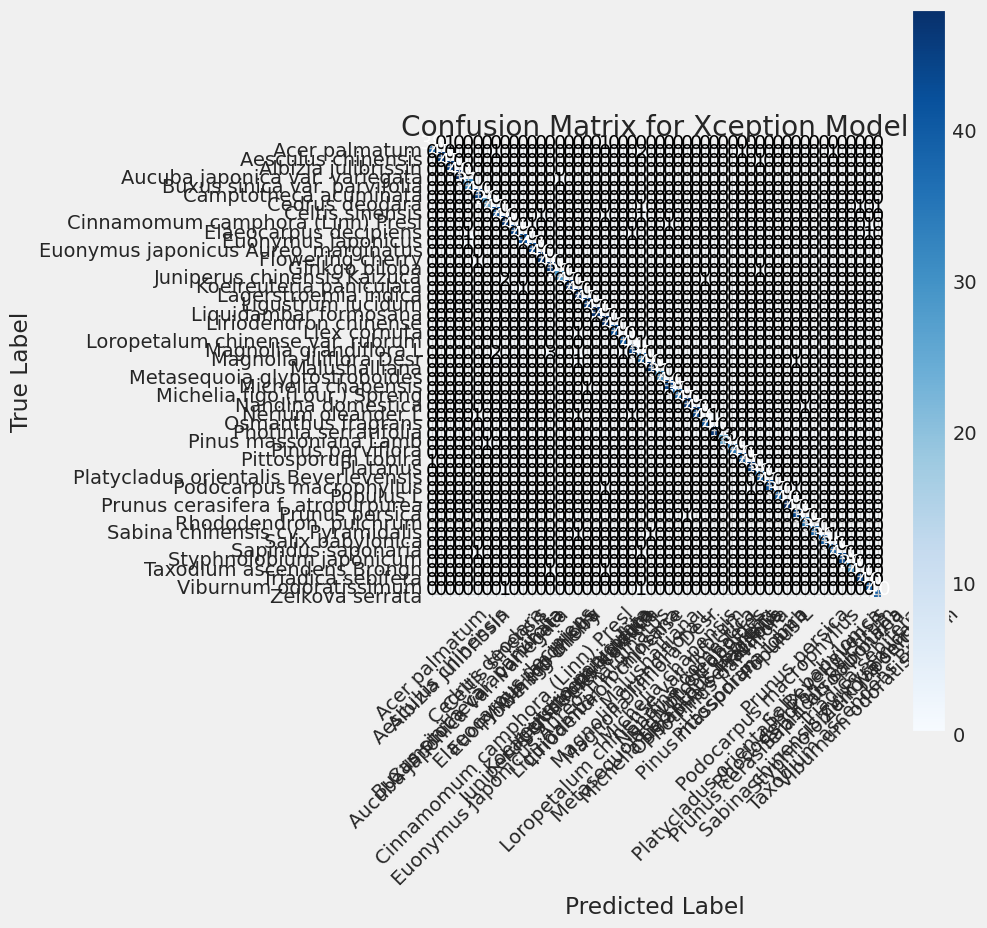

In [17]:
g_dict_xception = test_gen.class_indices
classes_xception = list(g_dict_xception.keys())  

cm_xception = confusion_matrix(test_gen.classes, y_pred_xception)  
plot_confusion_matrix(cm=cm_xception, classes=classes_xception, title='Confusion Matrix for Xception Model')

In [18]:
print(classification_report(test_gen.classes, y_pred_xception, target_names= classes_xception)) 

                                      precision    recall  f1-score   support

                       Acer palmatum       0.97      0.95      0.96        40
                  Aesculus chinensis       1.00      0.90      0.95        50
                 Albizia julibrissin       0.98      0.98      0.98        46
      Aucuba japonica var. variegata       1.00      1.00      1.00        48
        Buxus sinica var. parvifolia       0.94      0.97      0.95        32
               Camptotheca acuminata       0.94      1.00      0.97        44
                      Cedrus deodara       0.96      1.00      0.98        26
                     Celtis sinensis       0.93      0.93      0.93        45
    Cinnamomum camphora (Linn) Presl       0.94      0.94      0.94        49
               Elaeocarpus decipiens       1.00      0.94      0.97        47
                  Euonymus japonicus       0.95      0.93      0.94        45
 Euonymus japonicus Aureo_marginatus       0.98      0.96      

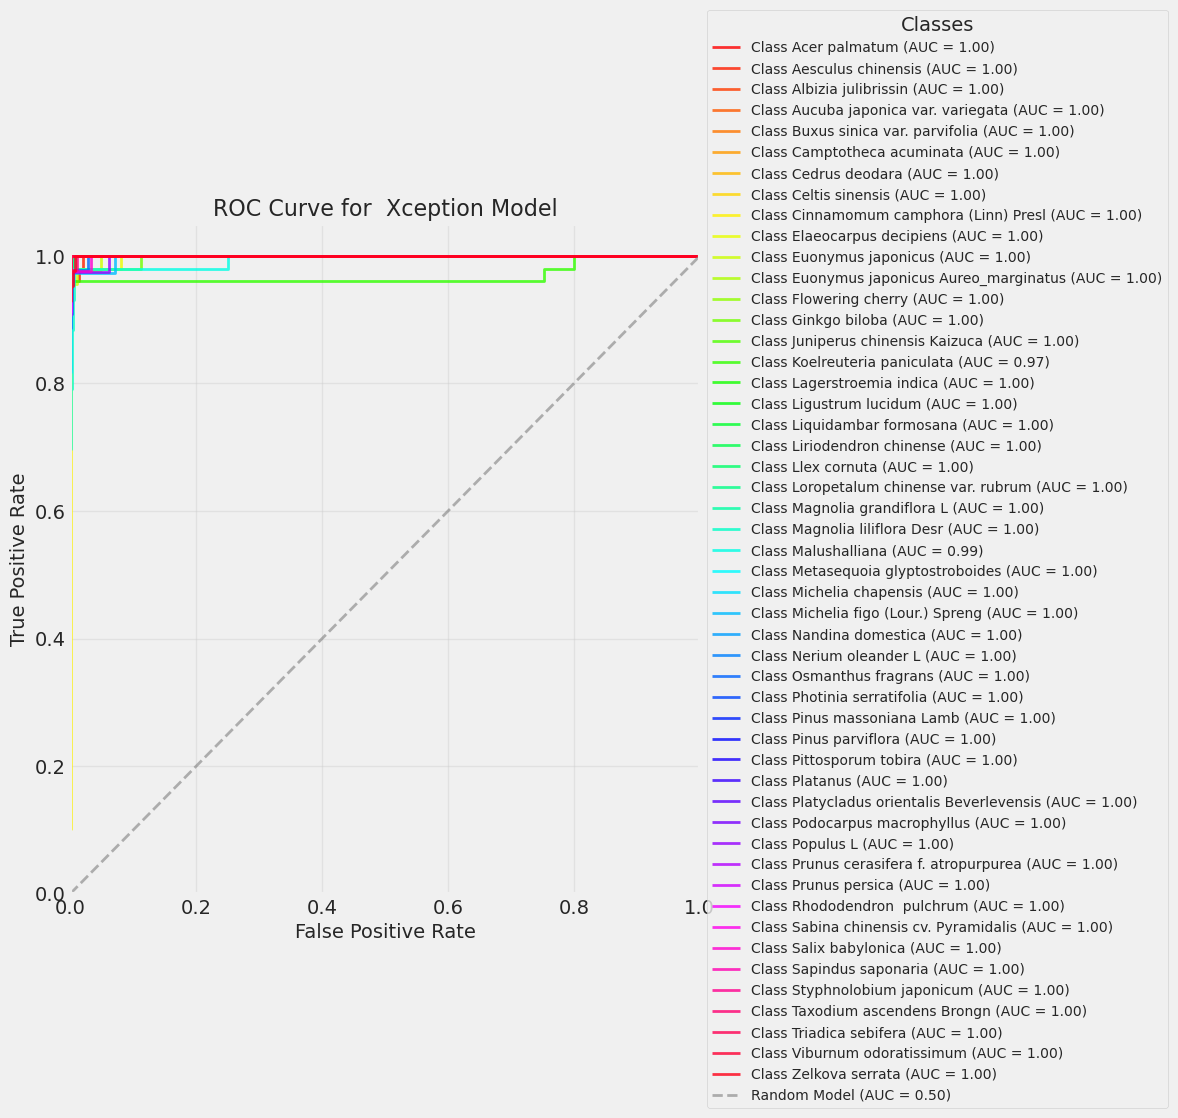

In [19]:
plot_roc_auc(y_true=test_gen.classes, y_pred_prob=preds_xception, classes=classes_xception, model_name=' Xception Model')

# **DenseNet Model**

In [10]:
img_size_dense = (200, 200)  
channels_dense = 3  
img_shape_dense = (img_size_dense[0], img_size_dense[1], channels_dense)  
class_count_dense = len(list(train_gen.class_indices.keys()))  

base_model_dense = tf.keras.applications.DenseNet121(include_top=False, weights="imagenet",  input_shape=img_shape_dense, pooling='max')
base_model_dense.trainable = True  

model_dense = Sequential([base_model_dense, BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),  
    Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l2(0.01), activation='relu'),  
    Dropout(rate=0.5, seed=123),  
    Dense(class_count_dense, activation='softmax')  
])

reduce_lr_dense = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

model_dense.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy']) 
model_dense.summary()

29084464/29084464 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1024)              7037504   
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                12850     
                                                                 
Total params: 7,316,850
Trainable params: 7,231,154
Non-t

In [11]:
batch_size_dense = 32
callbacks_dense = [MyCallback(model=model_dense,patience=1,stop_patience=3,threshold=0.9,factor=0.5,
                              batches=int(np.ceil(len(train_gen.labels) / batch_size_dense)),  epochs=10, ask_epoch=5)]
callbacks_dense.append(reduce_lr_dense)

In [12]:
history_dense = model_dense.fit(x=train_gen, epochs=10, verbose=0, callbacks=callbacks_dense,
                                 validation_data=valid_gen, validation_steps=None, shuffle=False)   

Do you want model asks you to halt the training [y/n] ?


 n


 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /10     6.653   37.070   4.35312  66.460   0.00100  0.00100  accuracy     0.00    781.19 
 2 /10     3.267   76.356   2.44771  83.865   0.00100  0.00100  accuracy    105.98   583.36 
 3 /10     1.892   89.286   1.68273  84.900   0.00100  0.00100  accuracy    16.93    573.47 
 4 /10     1.232   93.587   1.12787  90.278   0.00100  0.00100  val_loss    32.97    577.64 
 5 /10     0.929   95.109   1.17080  83.806   0.00100  0.00050  val_loss    -3.81    575.16 
 6 /10     0.691   98.330   0.69505  95.863   0.00050  0.00050  val_loss    38.38    575.25 
 7 /10     0.591   99.025   0.62016  96.277   0.00050  0.00050  val_loss    10.77    575.23 
 8 /10     0.544   99.039   0.58436  95.981   0.00050  0.00050  val_loss     5.77    577.64 
 9 /10     0.493   99.453   0.52313  96.838   0.00050  0.00050  val_loss    10.48    571.63 
10 /10     0.465   99.416   0.51750  96.572   0.00050  0.00050  val_los

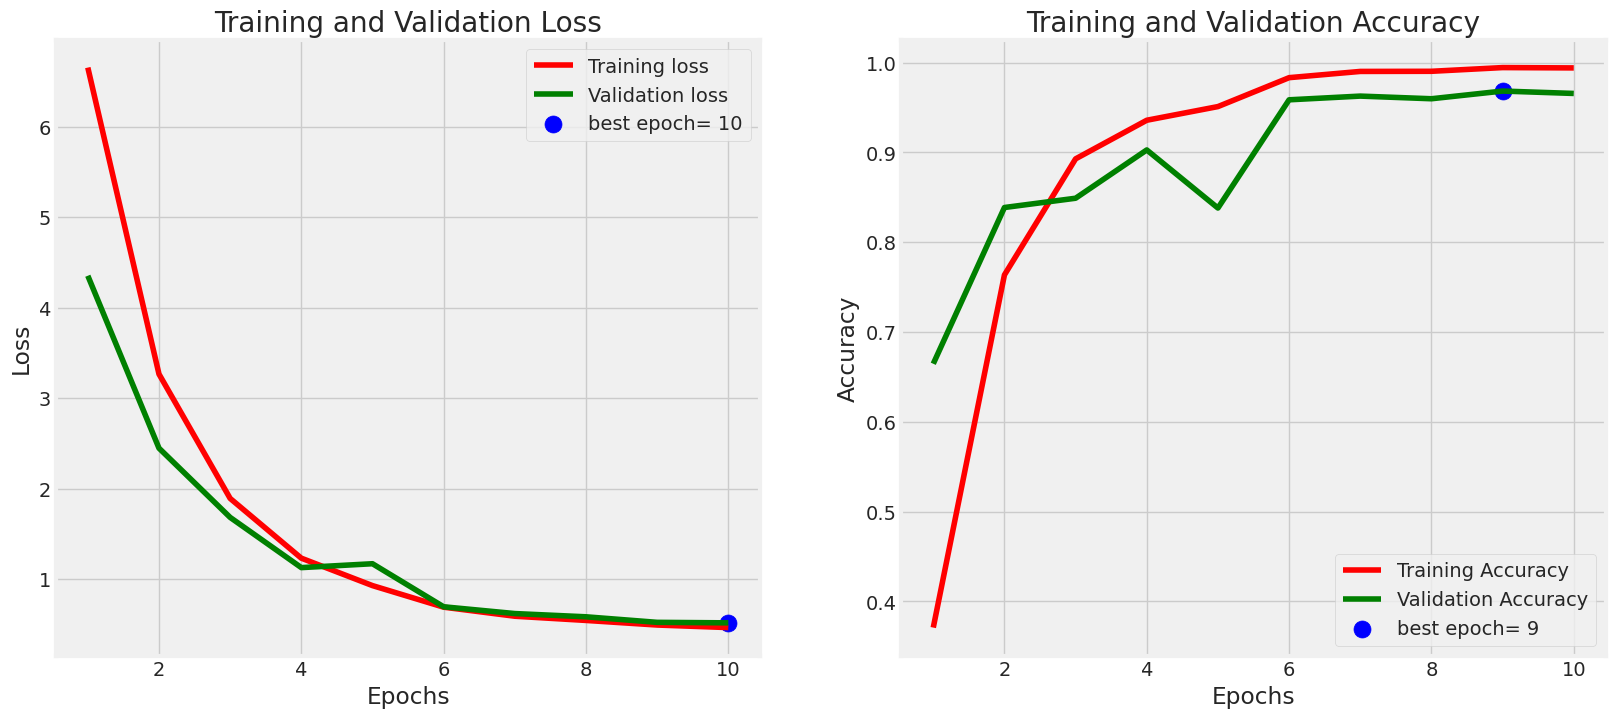

In [13]:
plot_training(history_dense) 

**Evaluate DenseNet Model**

In [14]:
ts_length_dense = len(test_df)
test_batch_size_dense = max(sorted([ts_length_dense // n for n in range(1, ts_length_dense + 1) if ts_length_dense % n == 0 and ts_length_dense / n <= 80]))
test_steps_dense = ts_length_dense // test_batch_size_dense

train_score_dense = model_dense.evaluate(train_gen, steps=test_steps_dense, verbose=1)
valid_score_dense = model_dense.evaluate(valid_gen, steps=test_steps_dense, verbose=1)
test_score_dense = model_dense.evaluate(test_gen, steps=test_steps_dense, verbose=1)

print("DenseNet121 Model Accuracy")
print("Train Loss: ", train_score_dense[0])
print("Train Accuracy: ", train_score_dense[1])
print('-' * 20)
print("Validation Loss: ", valid_score_dense[0])
print("Validation Accuracy: ", valid_score_dense[1])
print('-' * 20)
print("Test Loss: ", test_score_dense[0])
print("Test Accuracy: ", test_score_dense[1])


523/523 [==============================] - 90s 172ms/step - loss: 0.4932 - accuracy: 0.9742
DenseNet121 Model Accuracy
Train Loss:  0.3913452923297882
Train Accuracy:  0.9989655613899231
--------------------
Validation Loss:  0.5175047516822815
Validation Accuracy:  0.9657210111618042
--------------------
Test Loss:  0.49316760897636414
Test Accuracy:  0.9741873741149902


In [15]:
preds_dense = model_dense.predict(test_gen)
y_pred_dense = np.argmax(preds_dense, axis=1)
print(y_pred_dense)

523/523 [==============================] - 73s 136ms/step
[28 28 28 ...  1  1  1]


Confusion Matrix:
[[38  0  0 ...  0  0  0]
 [ 0 50  0 ...  0  0  0]
 [ 0  0 45 ...  0  0  0]
 ...
 [ 0  0  0 ... 44  0  0]
 [ 0  0  0 ...  0 39  0]
 [ 0  0  0 ...  0  0 40]]


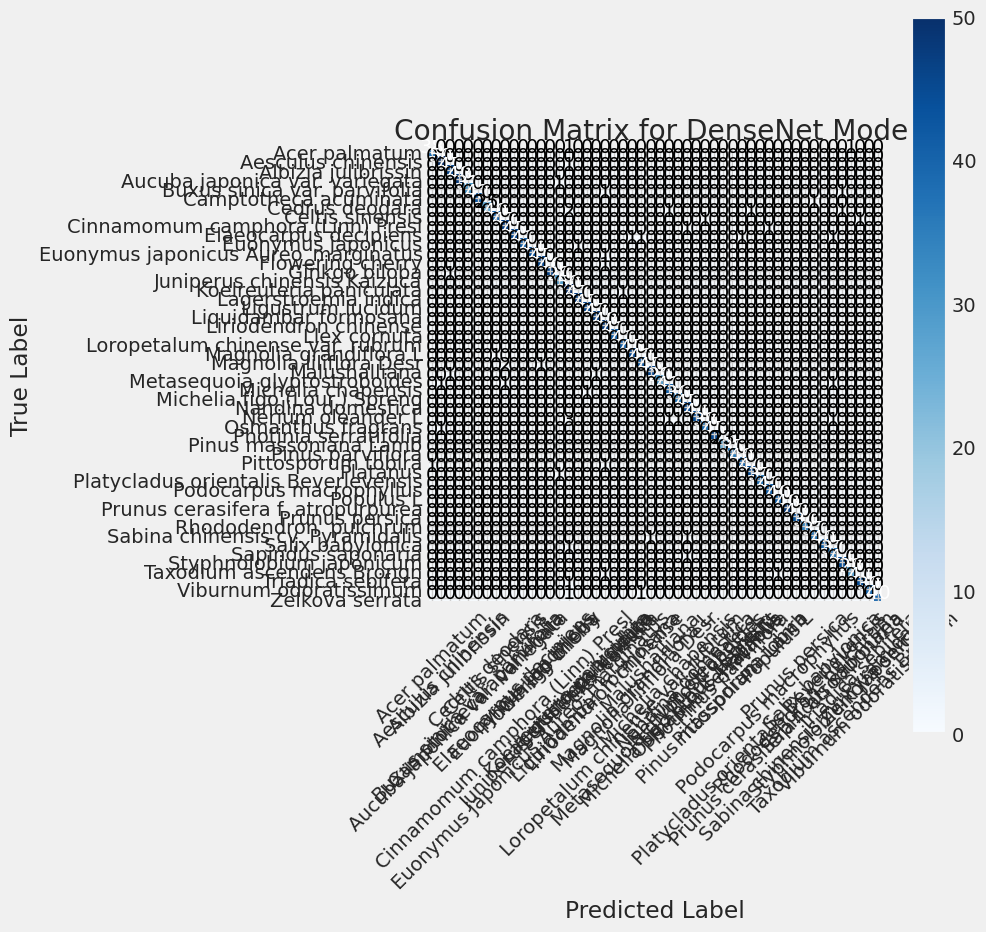

In [16]:
g_dict_dense = test_gen.class_indices
classes_dense = list(g_dict_dense.keys())

cm_dense = confusion_matrix(test_gen.classes, y_pred_dense)
plot_confusion_matrix(cm=cm_dense, classes=classes_dense, title='Confusion Matrix for DenseNet Model')

In [17]:
print(classification_report(test_gen.classes, y_pred_dense, target_names=classes_dense))

                                      precision    recall  f1-score   support

                       Acer palmatum       0.97      0.95      0.96        40
                  Aesculus chinensis       0.96      1.00      0.98        50
                 Albizia julibrissin       0.96      0.98      0.97        46
      Aucuba japonica var. variegata       1.00      1.00      1.00        48
        Buxus sinica var. parvifolia       1.00      0.97      0.98        32
               Camptotheca acuminata       1.00      0.95      0.98        44
                      Cedrus deodara       1.00      0.96      0.98        26
                     Celtis sinensis       0.98      0.89      0.93        45
    Cinnamomum camphora (Linn) Presl       0.94      0.96      0.95        49
               Elaeocarpus decipiens       1.00      0.96      0.98        47
                  Euonymus japonicus       1.00      0.91      0.95        45
 Euonymus japonicus Aureo_marginatus       1.00      0.98      

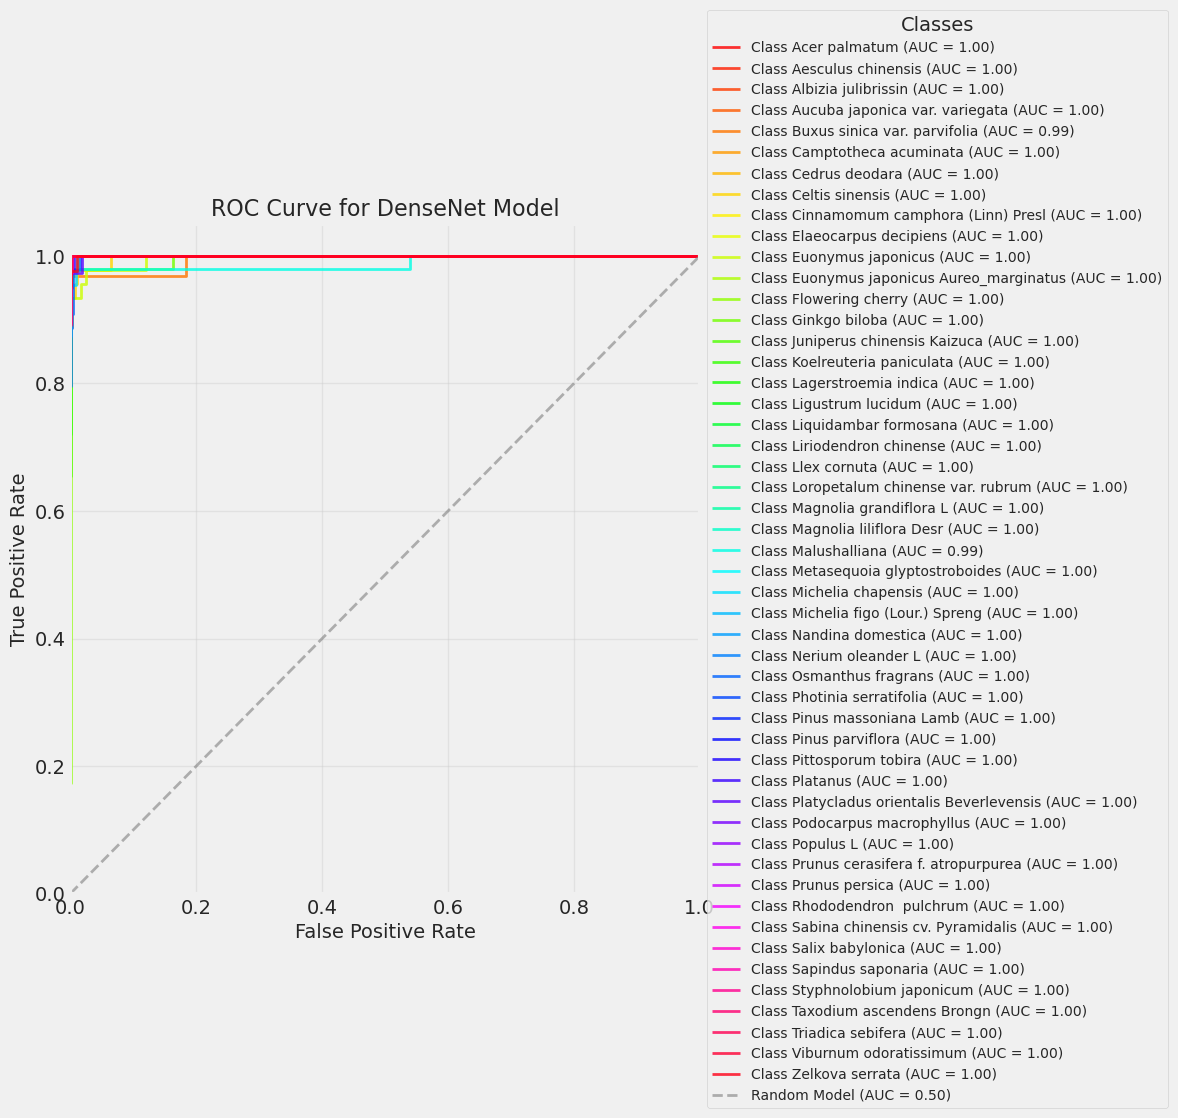

In [18]:
plot_roc_auc(y_true=test_gen.classes, y_pred_prob=preds_dense, classes=classes_dense, model_name='DenseNet Model')

# **ResNet50 Model from Scratch**

In [19]:
def identity_block(X, filters, kernel_size):
    
    F1, F2, F3 = filters
    X_shortcut = X
       # First component of the main path :1x1 with F1 filters
    X = layers.Conv2D(F1, (1, 1), strides=(1, 1), padding='valid', kernel_regularizer=regularizers.l2(0.001))(X)
    X = layers.BatchNormalization(axis=3)(X)
    X = layers.Activation('relu')(X)
       # Second component :kernel_size x kernel_size with F2 filters
    X = layers.Conv2D(F2, kernel_size, strides=(1, 1), padding='same', kernel_regularizer=regularizers.l2(0.001))(X)
    X = layers.BatchNormalization(axis=3)(X)
    X = layers.Activation('relu')(X)
       # Third component 
    X = layers.Conv2D(F3, (1, 1), strides=(1, 1), padding='valid', kernel_regularizer=regularizers.l2(0.001))(X)
    X = layers.BatchNormalization(axis=3)(X)
       ## Add the input (shortcut) to the output
    X = layers.Add()([X, X_shortcut])
    X = layers.Activation('relu')(X)

    return X

def convolutional_block(X, filters, kernel_size, strides=(2, 2)):
    F1, F2, F3 = filters
    X_shortcut = X
    
       # First component of the main path
    X = layers.Conv2D(F1, (1, 1), strides=strides, padding='valid')(X)
    X = layers.BatchNormalization(axis=3)(X)
    X = layers.Activation('relu')(X)
       # Second component 
    X = layers.Conv2D(F2, kernel_size, strides=(1, 1), padding='same')(X)
    X = layers.BatchNormalization(axis=3)(X)
    X = layers.Activation('relu')(X)
      # Third component 
    X = layers.Conv2D(F3, (1, 1), strides=(1, 1), padding='valid')(X)
    X = layers.BatchNormalization(axis=3)(X)

    # Shortcut path:# Adjust the shortcut path
    X_shortcut = layers.Conv2D(F3, (1, 1), strides=strides, padding='valid')(X_shortcut)
    X_shortcut = layers.BatchNormalization(axis=3)(X_shortcut)

    X = layers.Add()([X, X_shortcut])
    X = layers.Activation('relu')(X)

    return X

def ResNet50(input_shape=(224, 224, 3), classes=50):  
    X_input = layers.Input(input_shape)
    X = layers.ZeroPadding2D((3, 3))(X_input)

       # Stage 1 :Initial convolution and pooling
    X = layers.Conv2D(32, (7, 7), strides=(2, 2), padding='valid')(X)
    X = layers.BatchNormalization(axis=3)(X)
    X = layers.Activation('relu')(X)
    X = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(X)
      # Stage 2 
    X = convolutional_block(X, filters=[32, 32, 128], kernel_size=3, strides=(1, 1))
    X = identity_block(X, filters=[32, 32, 128], kernel_size=3)
      # Stage 3 
    X = convolutional_block(X, filters=[64, 64, 256], kernel_size=3)
    X = identity_block(X, filters=[64, 64, 256], kernel_size=3)
      # Stage 4 
    X = convolutional_block(X, filters=[128, 128, 512], kernel_size=3)
    X = identity_block(X, filters=[128, 128, 512], kernel_size=3)
      # Stage 5 (
    X = convolutional_block(X, filters=[256, 256, 1024], kernel_size=3)
    X = identity_block(X, filters=[256, 256, 1024], kernel_size=3)

    X = layers.GlobalAveragePooling2D()(X)
    X = layers.Dropout(0.45)(X)

    # Regularized Dense layer
    X = layers.Dense(256, kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l1(0.006),
                     bias_regularizer=regularizers.l1(0.006), activation='relu')(X)
    X = layers.Dense(classes, activation='softmax')(X)

    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

# Create the ResNet50 model
model = ResNet50(input_shape=(224, 224, 3), classes=50)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 32  4736        ['zero_padding2d_2[0][0]']       
                                )                                                          

In [20]:
reduce_lr_resnet = ReduceLROnPlateau(monitor='val_loss',factor=0.5,  patience=3,  min_lr=1e-6,  verbose=1)

In [21]:
batch_size_resnet= 40
callbacks_resnet = [MyCallback(model=model, patience=1, stop_patience=3, threshold=0.9, factor=0.5, 
                   batches=int(np.ceil(len(train_gen.labels) / batch_size_resnet)), epochs=10, ask_epoch=5), reduce_lr_resnet]

In [22]:
history_resnet = model.fit(x=train_gen, epochs=10, verbose=0, callbacks=callbacks_resnet,validation_data=valid_gen,
                            validation_steps=None,shuffle=False )

Do you want model asks you to halt the training [y/n] ?


 n


 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /10     9.619    4.611   8.83660   7.476   0.00010  0.00010  accuracy     0.00    584.96 
 2 /10     8.080   14.157   7.52100  14.509   0.00010  0.00010  accuracy    207.05   570.88 
 3 /10     6.822   23.326   6.80823  18.469   0.00010  0.00010  accuracy    64.77    569.62 
 4 /10     5.893   29.260   5.81649  23.936   0.00010  0.00010  accuracy    25.44    565.52 
 5 /10     5.216   34.240   5.22379  27.453   0.00010  0.00010  accuracy    17.02    567.56 
 6 /10     4.718   38.200   4.69316  34.102   0.00010  0.00010  accuracy    11.57    567.70 
 7 /10     4.313   42.441   4.35915  38.623   0.00010  0.00010  accuracy    11.10    572.73 
 8 /10     4.013   45.581   4.16725  37.648   0.00010  0.00010  accuracy     7.40    567.17 
 9 /10     3.748   48.973   3.82672  44.474   0.00010  0.00010  accuracy     7.44    566.59 
10 /10     3.520   52.276   3.46866  52.187   0.00010  0.00010  accurac

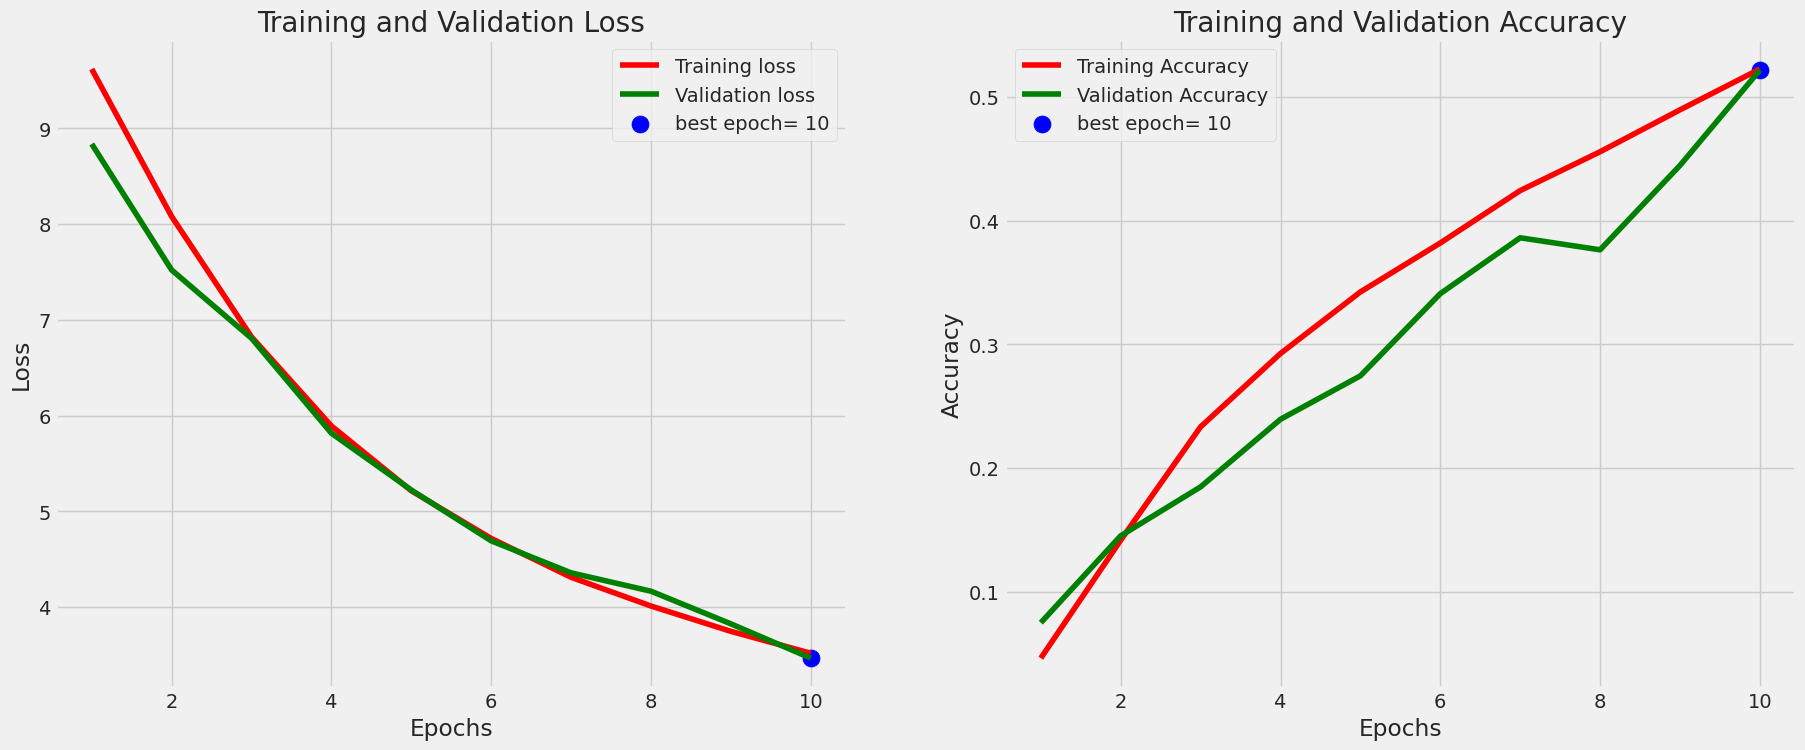

In [23]:
plot_training(history_resnet)

**Evaluate RESNET50 Model**

In [24]:
ts_length_resnet = len(test_df)
test_batch_size_resnet = max(sorted([ts_length_resnet // n for n in range(1, ts_length_resnet + 1) if ts_length_resnet % n == 0 and ts_length_resnet / n <= 80]))
test_steps_resnet = ts_length_resnet // test_batch_size_resnet

train_score_resnet = model.evaluate(train_gen, steps=test_steps_resnet, verbose=1)
valid_score_resnet = model.evaluate(valid_gen, steps=test_steps_resnet, verbose=1)
test_score_resnet = model.evaluate(test_gen, steps=test_steps_resnet, verbose=1)

print("ResNet50 Model Accuracy")
print("Train Loss: ", train_score_resnet[0]) 
print("Train Accuracy: ", train_score_resnet[1])
print('-' * 20)
print("Validation Loss: ", valid_score_resnet[0])
print("Validation Accuracy: ", valid_score_resnet[1])
print('-' * 20)
print("Test Loss: ", test_score_resnet[0])
print("Test Accuracy: ", test_score_resnet[1])  

523/523 [==============================] - 74s 141ms/step - loss: 3.5155 - accuracy: 0.4928
ResNet50 Model Accuracy
Train Loss:  3.3282275199890137
Train Accuracy:  0.5514999032020569
--------------------
Validation Loss:  3.4686617851257324
Validation Accuracy:  0.5218676328659058
--------------------
Test Loss:  3.515540838241577
Test Accuracy:  0.492829829454422


In [25]:
preds_resnet = model.predict(test_gen)
y_pred_resnet = np.argmax(preds_resnet, axis=1)
print(y_pred_resnet)

523/523 [==============================] - 72s 137ms/step
[ 5 28 28 ... 20 44  1]


Confusion Matrix:
[[ 6  0  2 ...  1  0  0]
 [ 0 34  0 ...  0  0  1]
 [ 1  2 23 ...  0  0  1]
 ...
 [ 1  3  0 ... 23  0  0]
 [ 0  3  0 ...  1 18  0]
 [ 0  2  3 ...  2  0 24]]


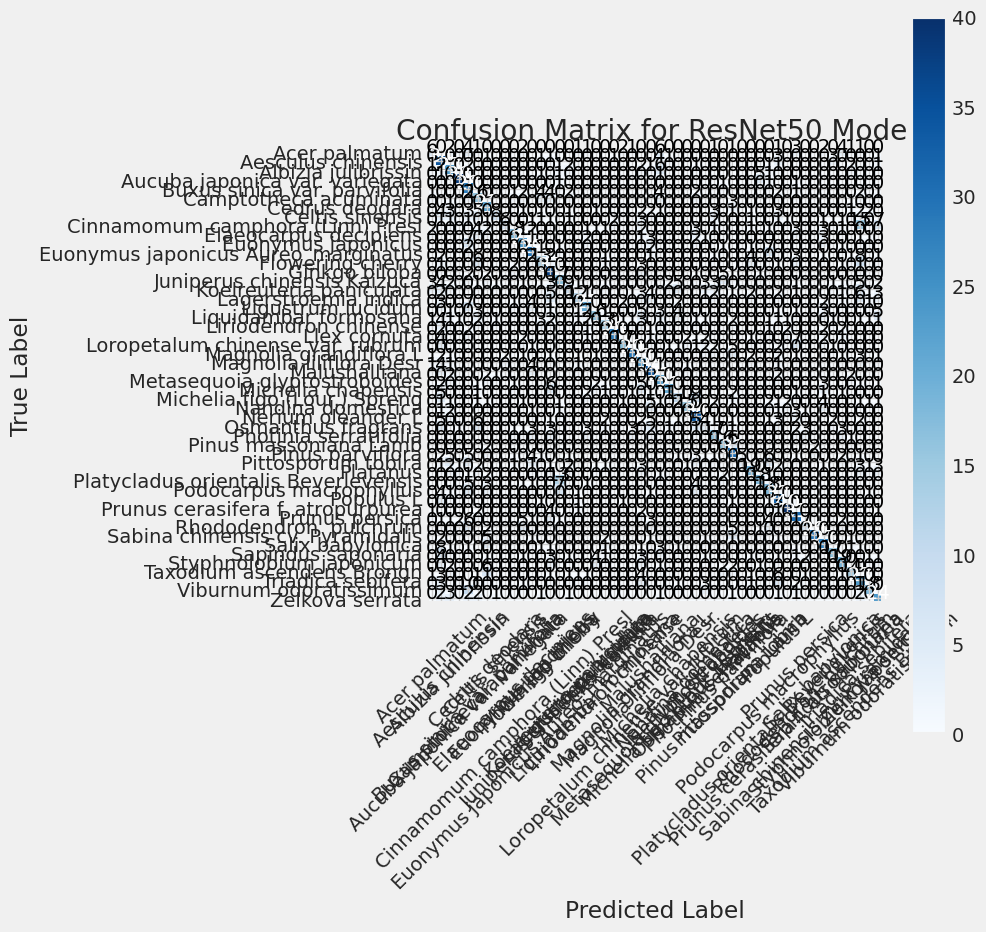

In [26]:
g_dict_resnet = test_gen.class_indices
classes_resnet = list(g_dict_resnet.keys())

cm_resnet = confusion_matrix(test_gen.classes, y_pred_resnet)
plot_confusion_matrix(cm=cm_resnet, classes=classes_resnet, title='Confusion Matrix for ResNet50 Model')

In [27]:
print(classification_report(test_gen.classes, y_pred_resnet, target_names=classes_resnet))

                                      precision    recall  f1-score   support

                       Acer palmatum       0.33      0.15      0.21        40
                  Aesculus chinensis       0.30      0.68      0.41        50
                 Albizia julibrissin       0.41      0.50      0.45        46
      Aucuba japonica var. variegata       0.88      0.79      0.84        48
        Buxus sinica var. parvifolia       0.31      0.88      0.46        32
               Camptotheca acuminata       0.30      0.36      0.33        44
                      Cedrus deodara       0.40      0.81      0.54        26
                     Celtis sinensis       0.67      0.18      0.28        45
    Cinnamomum camphora (Linn) Presl       0.75      0.12      0.21        49
               Elaeocarpus decipiens       0.69      0.38      0.49        47
                  Euonymus japonicus       0.53      0.51      0.52        45
 Euonymus japonicus Aureo_marginatus       0.52      0.64      

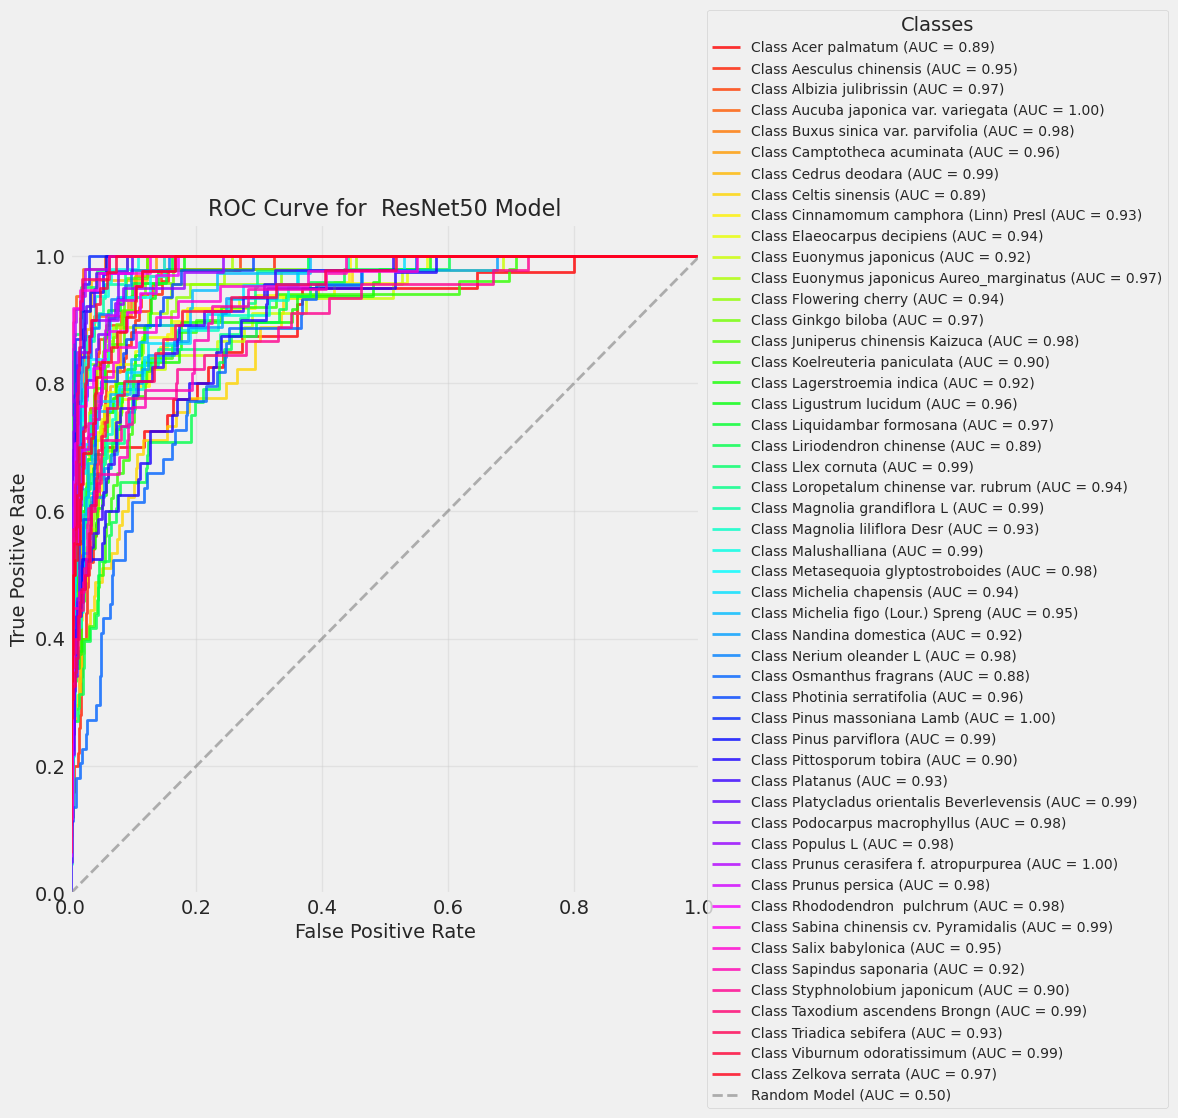

In [28]:
plot_roc_auc(y_true=test_gen.classes, y_pred_prob=preds_resnet, classes=classes_resnet, model_name=' ResNet50 Model')